# SCA koriscenjem deep learninga

U radu je do sada bilo prikazano nekoliko nacina izvlacenja tajni iz hardvera. State of the art pristup su template napadi koji su se pokazali kao standard u ovoj oblasti istrazivanja sigurnosti sistema. Kod template napada je potrebno ozbiljno preprocesiranje ulaznih podataka, potrebno je dosta iskustva. DPA i CPA su dovoljno jednostavni za koriscenje i implementaciju, ali je i za njih potreban relativno veliki broj trace-va i ne pokazuju se toliko dobro sa sumovitim podacima. Deep learning nastoji da eliminise neke od navedenih problema. 

# Arhitekture neuronskih mreza koje ce biti koriscene

U radu koji opisuje ASCAD bazu podataka date su i neke smernice oko odabira odgovarajucih modela i izbora hiperparametara. Preprocesiranje podataka i redukcija dimenzionalnosti nije potrebna, jer se ona obavi u prvim slojevima mreze.
Architecture choice is a difficult topic...

## MLP (multi-layered perceptron)

Obicna potpuno povezana neuronska mreza sa softmax aktivacijom. Broj slojeva i neurona po slojevima je tesko odrediti kao sto ce se videti u nastavku.

input sloj : 80.000 tacaka traceva
output sloj : 256 klasa za 256 mogucih vrednosti jednog bajta kljuca

In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import os
import numpy as np
import h5py
import tensorflow as tf
import keras
from datetime import datetime
import keras_tuner as kt
from tqdm.notebook import tqdm

C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from utils.data_preparation import SCAML_Dataset

In [3]:
EXECUTE_IN_COLAB = False
ATTACK_ALGORITHM = 'tinyaes'

if EXECUTE_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    data_root_path = '/content/drive/MyDrive/datasets/'
    log_root_path ='/content/drive/MyDrive/logs/'
    
    training_data_path = data_root_path + ATTACK_ALGORITHM + '/train'
    testing_data_path =  data_root_path + ATTACK_ALGORITHM + '/test'
else:    
    data_root_path = './data/SCA_datasets/datasets/' + ATTACK_ALGORITHM
    log_root_path = './logs/'
    
    training_data_path = data_root_path + '/train'
    testing_data_path = data_root_path + '/test'

In [6]:
ATTACK_POINT = 'sub_bytes_out'
KEY_BYTE = 0

# Reduce no. of trace data points
trace_length = 10000

X_train, y_train = create_data(training_data, ATTACK_POINT, KEY_BYTE, trace_length)
X_test, y_test = create_data(testing_data, ATTACK_POINT, KEY_BYTE, trace_length)

# Squeeze out the last dimension (used for CNN arch not needed for MLP arch)
X_train = tf.squeeze(X_train)
X_test = tf.squeeze(X_test)

Loading shards:   0%|          | 0/256 [00:00<?, ?it/s]

Loading shards:   0%|          | 0/256 [00:00<?, ?it/s]

In [30]:
print(f"X_train shape {tf.shape(X_train)}")
print(f"y_train shape {tf.shape(y_train)}")

X_train shape [65536 10000]
y_train shape [65536   256]


In [8]:
batch_size, input_vector_shape = tf.shape(X_train)[0], tf.shape(X_train)[1]
print(f"Training batch size: {batch_size}\nInput shape: {input_vector_shape}")

Training batch size: 65536
Input shape: 10000


In [ ]:
dataset = SCAML_Dataset()

training_array = dataset.load_shards(training_data_path)
testing_array = dataset.load_shards(testing_data_path)

ATTACK_POINT = 'sub_bytes_out'
ATTACK_BYTE = 0

(X_train, y_train) = dataset.create_data(training_array, ATTACK_POINT, ATTACK_BYTE, 10000)
(X_test, y_test, keys, plaintexts) = dataset.create_data(testing_array, ATTACK_POINT, ATTACK_BYTE, 10000, attack = True)

256it [00:00, 5224.74it/s]
256it [00:00, 5566.63it/s]
Loading shards:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 225/256 [00:40<00:05,  5.25it/s]

In [ ]:
input_vector_shape = X_train_scaaml.shape[1]

### Sequential Keras API

In [9]:
leaky_relu_alpha = 0.2

MLP_sequential_base = keras.models.Sequential()

# Input layer
MLP_sequential_base.add(
    keras.layers.Dense(
        name='input_layer',
        units=10000,
        input_dim=input_vector_shape
    )
)

MLP_sequential_base.add(keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

# Hidden layer 1
MLP_sequential_base.add(
    keras.layers.Dense(
        name='layer_1',
        units=5000
    )
)

MLP_sequential_base.add(keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

# Hidden layer 2
MLP_sequential_base.add(
    keras.layers.Dense(
        name='layer_2',
        units=2500,
        activation='relu'
    )
)

MLP_sequential_base.add(keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

# # Hidden layer 3
# MLP_sequential_base.add(
#     keras.layers.Dense(
#         name='layer_3',
#         units=2500,
#         activation='relu'
#     )
# )

# # Hidden layer 4
# MLP_sequential_base.add(
#     keras.layers.Dense(
#         name='layer_4',
#         units=2500,
#         activation='relu'
#     )
# )

# Output layer
MLP_sequential_base.add(
    keras.layers.Dense(
        name='output_layer',
        units=256,
        activation='softmax'
    )
)

MLP_base_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

MLP_sequential_base.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_base_optimizer, 
                 metrics=['accuracy',
                         'Recall'])

MLP_sequential_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 10000)             100010000 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10000)             0         
                                                                 
 layer_1 (Dense)             (None, 5000)              50005000  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5000)              0         
                                                                 
 layer_2 (Dense)             (None, 2500)              12502500  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2500)              0         
                                                                 
 output_layer (Dense)        (None, 256)               6

In [10]:
#TODO: create before writing
model_img_path = './images/' + MLP_sequential_base.name
tf.keras.utils.plot_model(MLP_sequential_base, show_shapes=True, to_file=model_img_path)

FileNotFoundError: [Errno 2] No such file or directory: './images/sequential'

In [11]:
def train_model(model, X_train, y_train, batch_size, epochs, validation_data, plot_metrics=True):
    """! Train model and log training process to tensorboard
    
    @param model Model to train
    @param X_train Model inputs
    @param y_train Correct labels
    @param batch_size Size of the input batch
    @param epochs Number of epochs to train
    @param validation_data Validation data tuple in the format (X_val, y_val)
    """
        
    _log_dir = './logs/' + 'MLP_' + datetime.now().strftime("%Y-%d-%m_%H-%M")

    callbacks_list = [
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
        tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1)
    ]

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data = validation_data,
        callbacks=callbacks_list
    )
    
#     if plot_metrics:
#         model.metrics
    
    return history

In [12]:
# Train base MLP
history = train_model(MLP_sequential_base, X_train, y_train, 100, 10, (X_test, y_test))

Epoch 1/10
656/656 [==============================] - 460s 701ms/step - loss: 91.8618 - accuracy: 0.0031 - recall: 3.5095e-04 - val_loss: 5.5455 - val_accuracy: 0.0039 - val_recall: 0.0000e+00
Epoch 2/10
656/656 [==============================] - 484s 730ms/step - loss: 5.5470 - accuracy: 0.0037 - recall: 0.0000e+00 - val_loss: 5.5453 - val_accuracy: 0.0039 - val_recall: 0.0000e+00
Epoch 3/10
656/656 [==============================] - 474s 719ms/step - loss: 5.5470 - accuracy: 0.0034 - recall: 0.0000e+00 - val_loss: 5.5453 - val_accuracy: 0.0039 - val_recall: 0.0000e+00
Epoch 4/10
656/656 [==============================] - 500s 728ms/step - loss: 5.5470 - accuracy: 0.0036 - recall: 0.0000e+00 - val_loss: 5.5453 - val_accuracy: 0.0039 - val_recall: 0.0000e+00
Epoch 5/10
656/656 [==============================] - 556s 829ms/step - loss: 5.5470 - accuracy: 0.0034 - recall: 0.0000e+00 - val_loss: 5.5453 - val_accuracy: 0.0039 - val_recall: 0.0000e+00
Epoch 6/10
656/656 [===================

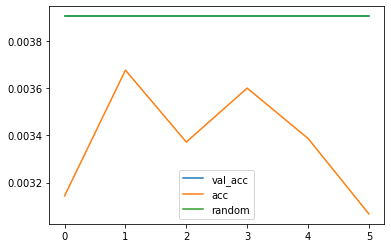

In [23]:
random_accuracy = [1/256] * len(history.history['val_accuracy'])

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(random_accuracy)
plt.legend(['val_acc', 'acc', 'random'],loc='best')
plt.show()

Model gotovo nista nije naucio i preciznost je cak i gora od nasumicnog pogadjanja (1/256 ~ 0.0039)
Stoga nema puno smisla evaluirati model i vrsiti kriptografske transformacije kako bi se otkrio kljuc.

### Hypertuning

Posto su rezultati treninga "na slepo" nezavidni, bice koriscen tuner hiperparametara keras ekosistema.

In [19]:
# Sequential model builder

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
    no_layers = hp.Int('num_layers', min_value=2, max_value=10)
    for layer in range(no_layers):
        model.add(
            keras.layers.Dense(
                units = hp.Int('units', min_value=500, max_value=5000, step=1000),
                activation = 'relu'
            )
        )
        
        # Optimize for batch normalization
        if layer == int(no_layers/2) and hp.Boolean('BatchNormalize'):
            model.add(keras.layers.BatchNormalization())
            
        model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Dense(units=256, activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy'])

    return model

In [20]:
tuner = kt.RandomSearch(hypermodel=build_model,
                    objective='val_accuracy',
                    max_trials=15,
                    executions_per_trial=2,
                    directory='./logs/hyperparam_tuning',
                    project_name='MLP_SCA_1.0')

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./logs/hyperparam_tuning\MLP_SCA_1.0\oracle.json
Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 5000, 'step': 1000, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [21]:
tensorboard_path  = "./logs/hyperparam_tuning/MLP_RandomSearch"
intermediate_path = "./logs/hyperparam_tuning/MLP_RandomSearch/tmp"

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

tuner.search(X_train, 
             y_train, 
             epochs=10, 
             validation_data=(X_test, y_test), 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
            )


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
num_layers        |10                |?                 
units             |4500              |?                 
BatchNormalize    |True              |?                 
learning_rate     |0.001             |?                 

Epoch 1/10
2048/2048 [==============================] - 1501s 732ms/step - loss: 5.5615 - accuracy: 0.0032 - val_loss: 5.5453 - val_accuracy: 0.0039
Epoch 2/10
2048/2048 [==============================] - 1559s 761ms/step - loss: 5.5473 - accuracy: 0.0027 - val_loss: 5.5452 - val_accuracy: 0.0039
Epoch 3/10
2048/2048 [==============================] - 1543s 754ms/step - loss: 5.5464 - accuracy: 0.0034 - val_loss: 5.5452 - val_accuracy: 0.0039
Epoch 4/10
2048/2048 [==============================] - 1544s 754ms/step - loss: 5.5464 - accuracy: 0.0028 - val_loss: 5.5452 - val_accuracy: 0.0039
Epoch 5/10
1084/2048 [==============>...............] - ETA: 10:58 - loss: 5.5460 - accurac

KeyboardInterrupt: 

In [25]:
y_train

<tf.Tensor: shape=(65536, 256), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

### Functional Keras API

In [ ]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=10000, activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=5000, activation='relu')(x)

# Batch normalization layer
x = keras.layers.BatchNormalization(name='batch_norm_1')(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=2500, activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=1000, activation='relu')(x)

# Batch normalization layer
x = keras.layers.BatchNormalization(name='batch_norm_2')(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=500, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP_functional = keras.Model(inputs=inputs, outputs=outputs, name='functional_MLP')

In [ ]:
MLP_functional.summary()

In [ ]:
tf.keras.utils.plot_model(MLP_functional, show_shapes=True)

In [ ]:
MLP_test_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

MLP_functional.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_test_optimizer, 
                 metrics=['accuracy', 'Recall'])

In [ ]:
from datetime import datetime

log_dir = './logs/' + 'MLP_' + datetime.now().strftime("%Y-%d-%m_%H-%M")

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

history = MLP_test.fit(
    X_train_reduced,
    y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data = (X_test_reduced, y_test),
    callbacks=callbacks_list
)

### Hypertuning functional model

In [ ]:
import keras_tuner as kt

min_layers = 4
max_layers = 15

def build_model(hp):
    
    inputs = keras.Input(shape = (input_vector_shape,))
    
    x = inputs
    
    no_layers = hp.Int('num_layers', min_value=min_layers, max_value=max_layers)
    for layer in range(no_layers):
        
        x = keras.layers.Dense(units = hp.Int('units', min_value=500, max_value=10000, step=1000),
                               activation = 'relu')(x)
        
        # Optimize for batch normalization
        if layer == int(no_layers/2) and hp.Boolean('BatchNormalize'):
            x = keras.layers.BatchNormalization()(x)
        

    outputs = keras.layers.Dense(units=256, activation='softmax')(x)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 3e-2, 3e-3, 3e-4, 3e-5, 5e-2, 5e-3, 5e-4, 5e-5])
#     hp_learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',
                             'Recall'])

    return model

In [ ]:
tuner = kt.Hyperband(hypermodel=build_model,
                        objective='val_accuracy',
                        max_epochs=5,
                        hyperband_iterations=10,
                        overwrite=True,
                        directory='./logs/hyperparam_tuning',
                        project_name='MLP_SCA')

tuner.search_space_summary()

In [ ]:
tf.X_train.shape

In [ ]:
tensorboard_path = "./logs/hyperparam_tuning/tensorboard"
intermediate_path = "./logs/tmp_func"

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

tuner.search(X_train_squeezed[:,:20000], 
             y_train, 
             epochs=10, 
             validation_data=(X_test_squeezed[:,:20000], y_test), 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
                         )

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs/MLP_2022-19-08_12-58

U relativno malom broju epoha je funkcija gubitka prestala da se smanjuje. Moze se uvesti uslov ranijeg zaustavljanja ka callback u keras API-ju

In [ ]:
models_path = './models'
model_name = '/MLP_base_0.3'

MLP_test.save(models_path + model_name)

In [ ]:
import matplotlib.pyplot as plt

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
plt.plot()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
models_path = './models'
model_name = '/MLP_base'

MLP_test.save(models_path + model_name)

In [ ]:
# Evaluate the model
predictions = MLP_test.predict(X_test, verbose=1)

In [ ]:
predictions

In [ ]:
predictions

In [ ]:
# keras.utils.np_utils.to_categorical(predictions[0].max(), 256)
key_guess = np.argmax(predictions[0])
print(key_guess)
print(predictions[0][key_guess])
print(np.max(predictions[0]))

In [ ]:
labels

In [ ]:
prediction_classes = keras.utils.np_utils.to_categorical(np.argmax(predictions, axis=1), 256)

In [ ]:
np.argmax(prediction_classes, axis=1)

In [ ]:
prediction_success = np.sum(np.all(prediction_classes == labels, axis=1))
print(f"Model accuracy: {(prediction_success/X_train_.shape[0]) * 100}%")

# Hypertuning

Posto je ocigledno da se manualno napravljene mreze ponasaju veoma lose, odnosno nemaju nikakav ucinak na validacionom skupu podataka, potrebno je izmeniti parametre modela. Za ovo ce biti koriscen alat keras tuner.

In [ ]:
import keras_tuner as kt

In [ ]:
# Sequential model builder

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
    for no_layers in range(hp.Int('num_layers', min_value=4, max_value=10)):
        model.add(
            keras.layers.Dense(
                units = hp.Int('units', min_value=500, max_value=5000, step=1000),
                activation = 'relu'
            )
        )

    model.add(keras.layers.Dense(units=256, activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
#     hp_learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(hypermodel=build_model,
                    objective='val_accuracy',
                    max_epochs=5,
                    hyperband_iterations=10)

tuner.search_space_summary()

In [ ]:
tensorboard_path = "/logs"
intermediate_path = "/logs/tmp"

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

tuner.search(X_train[:,:20000,:], 
             y_train, 
             epochs=10, 
             validation_data=(X_test[:,:20000,:], y_test), 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
                         )

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()

In [ ]:
best_hyperparameters[0].get('layers')

### ResNet

### CNN (Convolutional Neural Network)

In [ ]:
def display_config(config_name, config):
    """Pretty print a config object in terminal.
    Args:
        config_name (str): name of the config
        config (dict): config to display
    """
    cprint(f"[{config_name}]", "magenta")
    cnt = 1
    for k, v in config.items():
        if cnt % 2:
            color = "cyan"
        else:
            color = "yellow"
        cprint(f"{k}:{v}", color)
        cnt += 1

In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Intro model."""

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

def block(x,
          filters,
          kernel_size=3,
          strides=1,
          conv_shortcut=False,
          activation="relu"):
    """Residual block with pre-activation
    From: https://arxiv.org/pdf/1603.05027.pdf

    Args:
        x: input tensor.
        filters (int): filters of the bottleneck layer.

        kernel_size(int, optional): kernel size of the bottleneck layer.
        defaults to 3.

        strides (int, optional): stride of the first layer.
        defaults to 1.

        conv_shortcut (bool, optional): Use convolution shortcut if True,
        otherwise identity shortcut. Defaults to False.

        use_batchnorm (bool, optional): Use batchnormalization if True.
        Defaults to True.

        activation (str, optional): activation function. Defaults to "relu".

    Returns:
        Output tensor for the residual block.
    """

    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    if conv_shortcut:
        shortcut = layers.Conv1D(4 * filters, 1, strides=strides)(x)
    else:
        if strides > 1:
            shortcut = layers.MaxPooling1D(1, strides=strides)(x)
        else:
            shortcut = x

    x = layers.Conv1D(filters, 1, use_bias=False, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv1D(filters,
                      kernel_size,
                      strides=strides,
                      use_bias=False,
                      padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv1D(4 * filters, 1)(x)
    x = layers.Add()([shortcut, x])
    return x


def stack(x, filters, blocks, kernel_size=3, strides=2, activation="relu"):
    """A set of stacked residual blocks.
    Args:
        filters (int): filters of the bottleneck layer.

        blocks (int): number of conv blocks to stack.

        kernel_size(int, optional): kernel size of the bottleneck layer.
        defaults to 3.

        strides (int, optional): stride used in the last block.
        defaults to 2.

        conv_shortcut (bool, optional): Use convolution shortcut if True,
        otherwise identity shortcut. Defaults to False.

        activation (str, optional): activation function. Defaults to "relu".

    Returns:
        tensor:Output tensor for the stacked blocks.
  """
    x = block(x,
              filters,
              kernel_size=kernel_size,
              activation=activation,
              conv_shortcut=True)
    for _ in range(2, blocks):
        x = block(x, filters, kernel_size=kernel_size, activation=activation)
    x = block(x, filters, strides=strides, activation=activation)
    return x


def Resnet1D(input_shape, attack_point, mdl_cfg, optim_cfg):  # pylint: disable=C0103
    del attack_point  # unused

    pool_size = mdl_cfg["initial_pool_size"]
    filters = mdl_cfg["initial_filters"]
    block_kernel_size = mdl_cfg["block_kernel_size"]
    activation = mdl_cfg["activation"]
    dense_dropout = mdl_cfg["dense_dropout"]
    num_blocks = [
        mdl_cfg["blocks_stack1"], mdl_cfg["blocks_stack2"],
        mdl_cfg["blocks_stack3"], mdl_cfg["blocks_stack4"]
    ]

    inputs = layers.Input(shape=(input_shape))
    x = inputs

    # stem
    x = layers.MaxPool1D(pool_size=pool_size)(x)

    # trunk: stack of residual block
    for block_idx in range(4):
        filters *= 2
        x = stack(x,
                  filters,
                  num_blocks[block_idx],
                  kernel_size=block_kernel_size,
                  activation=activation)

    # head model: dense
    x = layers.GlobalAveragePooling1D()(x)
    for _ in range(1):
        x = layers.Dropout(dense_dropout)(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)

    outputs = layers.Dense(256, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    lr = optim_cfg["lr"]

    model.compile(loss=["categorical_crossentropy"],
                  metrics=["acc"],
                  optimizer=Adam(lr))
    return model


def get_model(input_shape, attack_point, config):
    """Return an instantiated model based of the config provided.

    Args:
        config (dict): scald config.
    """

    mdl_cfg = config["model_parameters"]
    optim_cfg = config["optimizer_parameters"]

    display_config("model", mdl_cfg)
    display_config("optimizer", optim_cfg)
    return Resnet1D(input_shape, attack_point, mdl_cfg, optim_cfg)

In [ ]:
from cprint import cprint

In [ ]:
cfg = {
    "model": "cnn",
    "device": "stm32f415",
    "algorithm": "tinyaes",
    "version": "10",
    "attack_points": [
        "sub_bytes_out"
    ],
    "attack_bytes": [
        "0"
    ],
    "max_trace_len": 10000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 10,
    "optimizer_parameters": {
        "lr": 0.001,
        "multi_gpu_lr": 0.001
    },
    "model_parameters": {
        "activation": "relu",
        "initial_filters": 8,
        "initial_pool_size": 4,
        "block_kernel_size": 3,
        "blocks_stack1": 3,
        "blocks_stack2": 4,
        "blocks_stack3": 4,
        "blocks_stack4": 3,
        "dense_dropout": 0.1
    }
}

In [ ]:
from termcolor import cprint

In [ ]:
model_scaml = get_model(X_train[:,:20000,:].shape[1:], 'sub_bytes_out', cfg )

In [ ]:
y_test

In [ ]:
model_scaml.fit(X_train[:,:20000,:],
          y_train,
          validation_data=(X_test[:,:20000,:], y_test),
          verbose=1,
          epochs=cfg["epochs"])

In [ ]:
scaml_predictions = model_scaml.predict(X_test[:,:20000,:], verbose=1)

In [ ]:
scaml_predictions

In [ ]:
print(np.argmax(scaml_predictions, axis=1).shape)
print(np.argmax(scaml_predictions, axis=1))

In [ ]:
print(training_data[0]['sub_bytes_out'])

In [ ]:
model_scaml.save(models_path + '/scaml_model_trained')

# Tips:

## start simple (underfit) or start complex (overfit)

## Don't need great accuracy => slightly above random could work with enough traces